# Coronavirus Evolution Forecast with FBProphet

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import mplcyberpunk
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import ParameterGrid
plt.style.use("cyberpunk")

In [2]:
plt.rcParams["figure.figsize"] = (12,4)
plt.rcParams['figure.dpi']= 300
plt.rcParams['lines.linewidth'] = 1

In [3]:
df = pd.read_csv(r"D:\PycharmProjects\misc\covid19\owid-covid-data.csv", parse_dates=['date'], index_col='date')

In [4]:
df = df.sort_index()

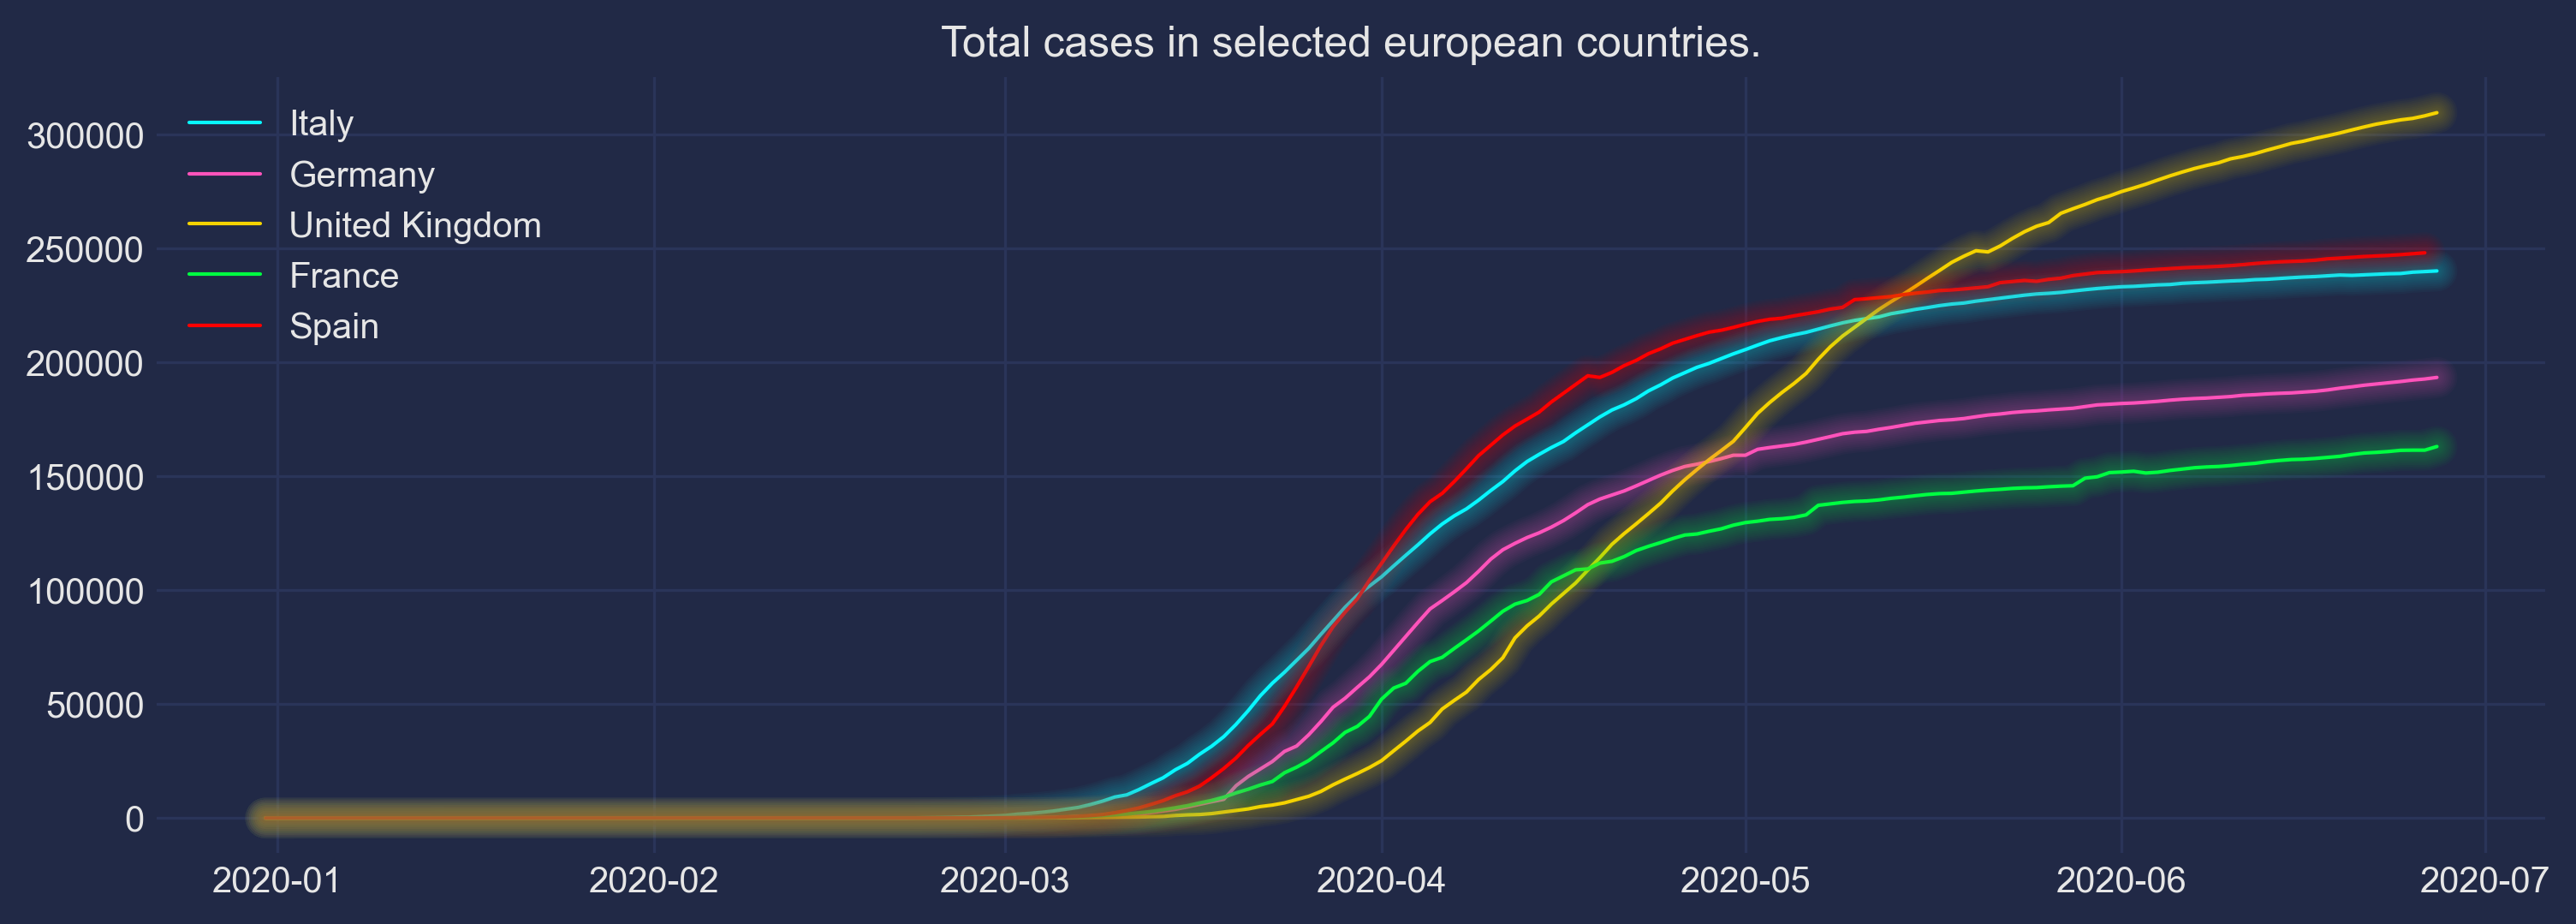

In [5]:
fig, ax = plt.subplots()
for country in ['Italy', 'Germany', 'United Kingdom', 'France', 'Spain']:
    ax.plot(df[df['location']==country]['total_cases'], label=country)
plt.legend()
plt.title('Total cases in selected european countries.')
mplcyberpunk.make_lines_glow()

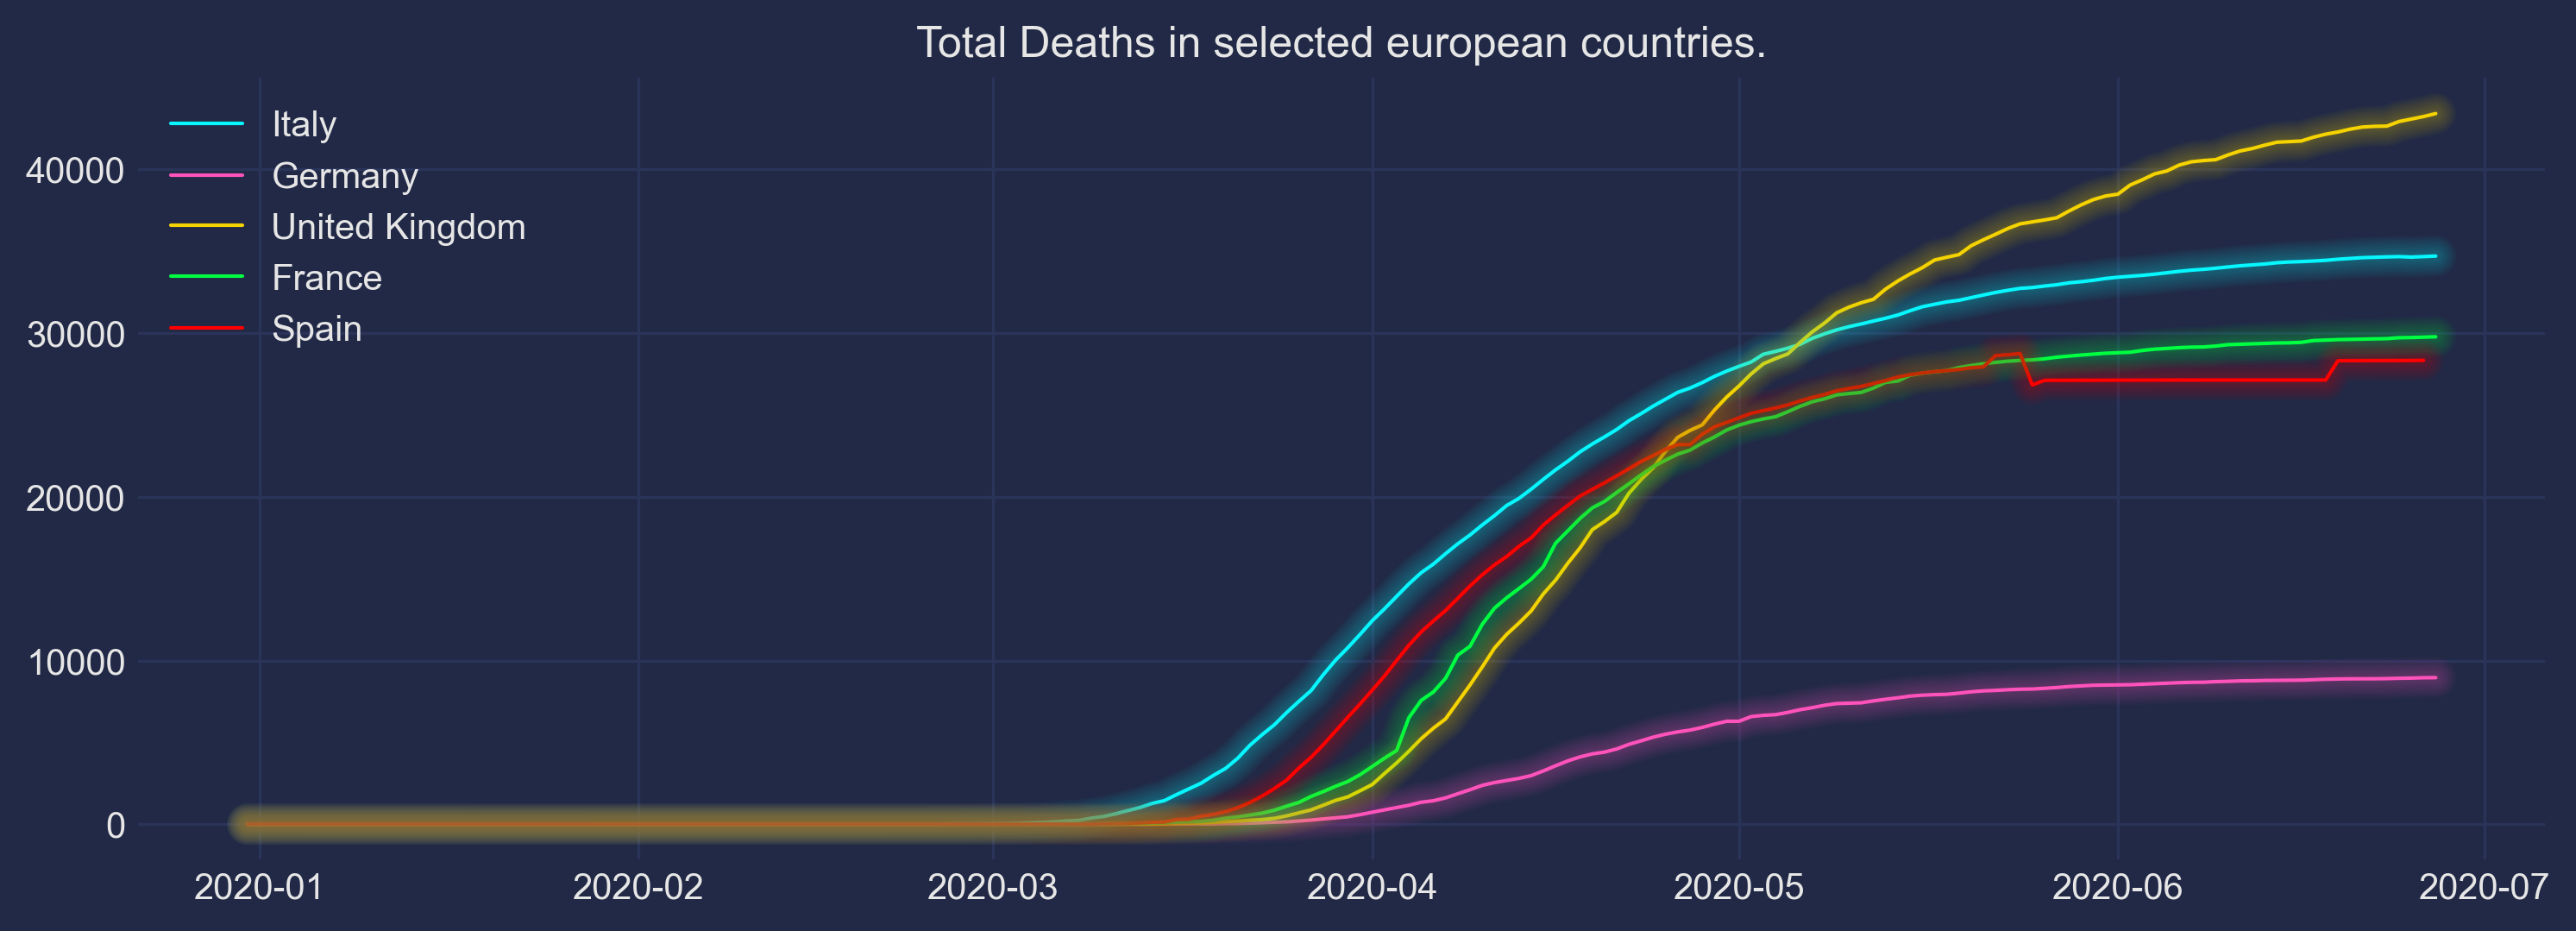

In [6]:
fig, ax = plt.subplots()
for country in ['Italy', 'Germany', 'United Kingdom', 'France', 'Spain']:
    ax.plot(df[df['location']==country]['total_deaths'], label=country)
plt.legend()
plt.title('Total Deaths in selected european countries.')
mplcyberpunk.make_lines_glow()

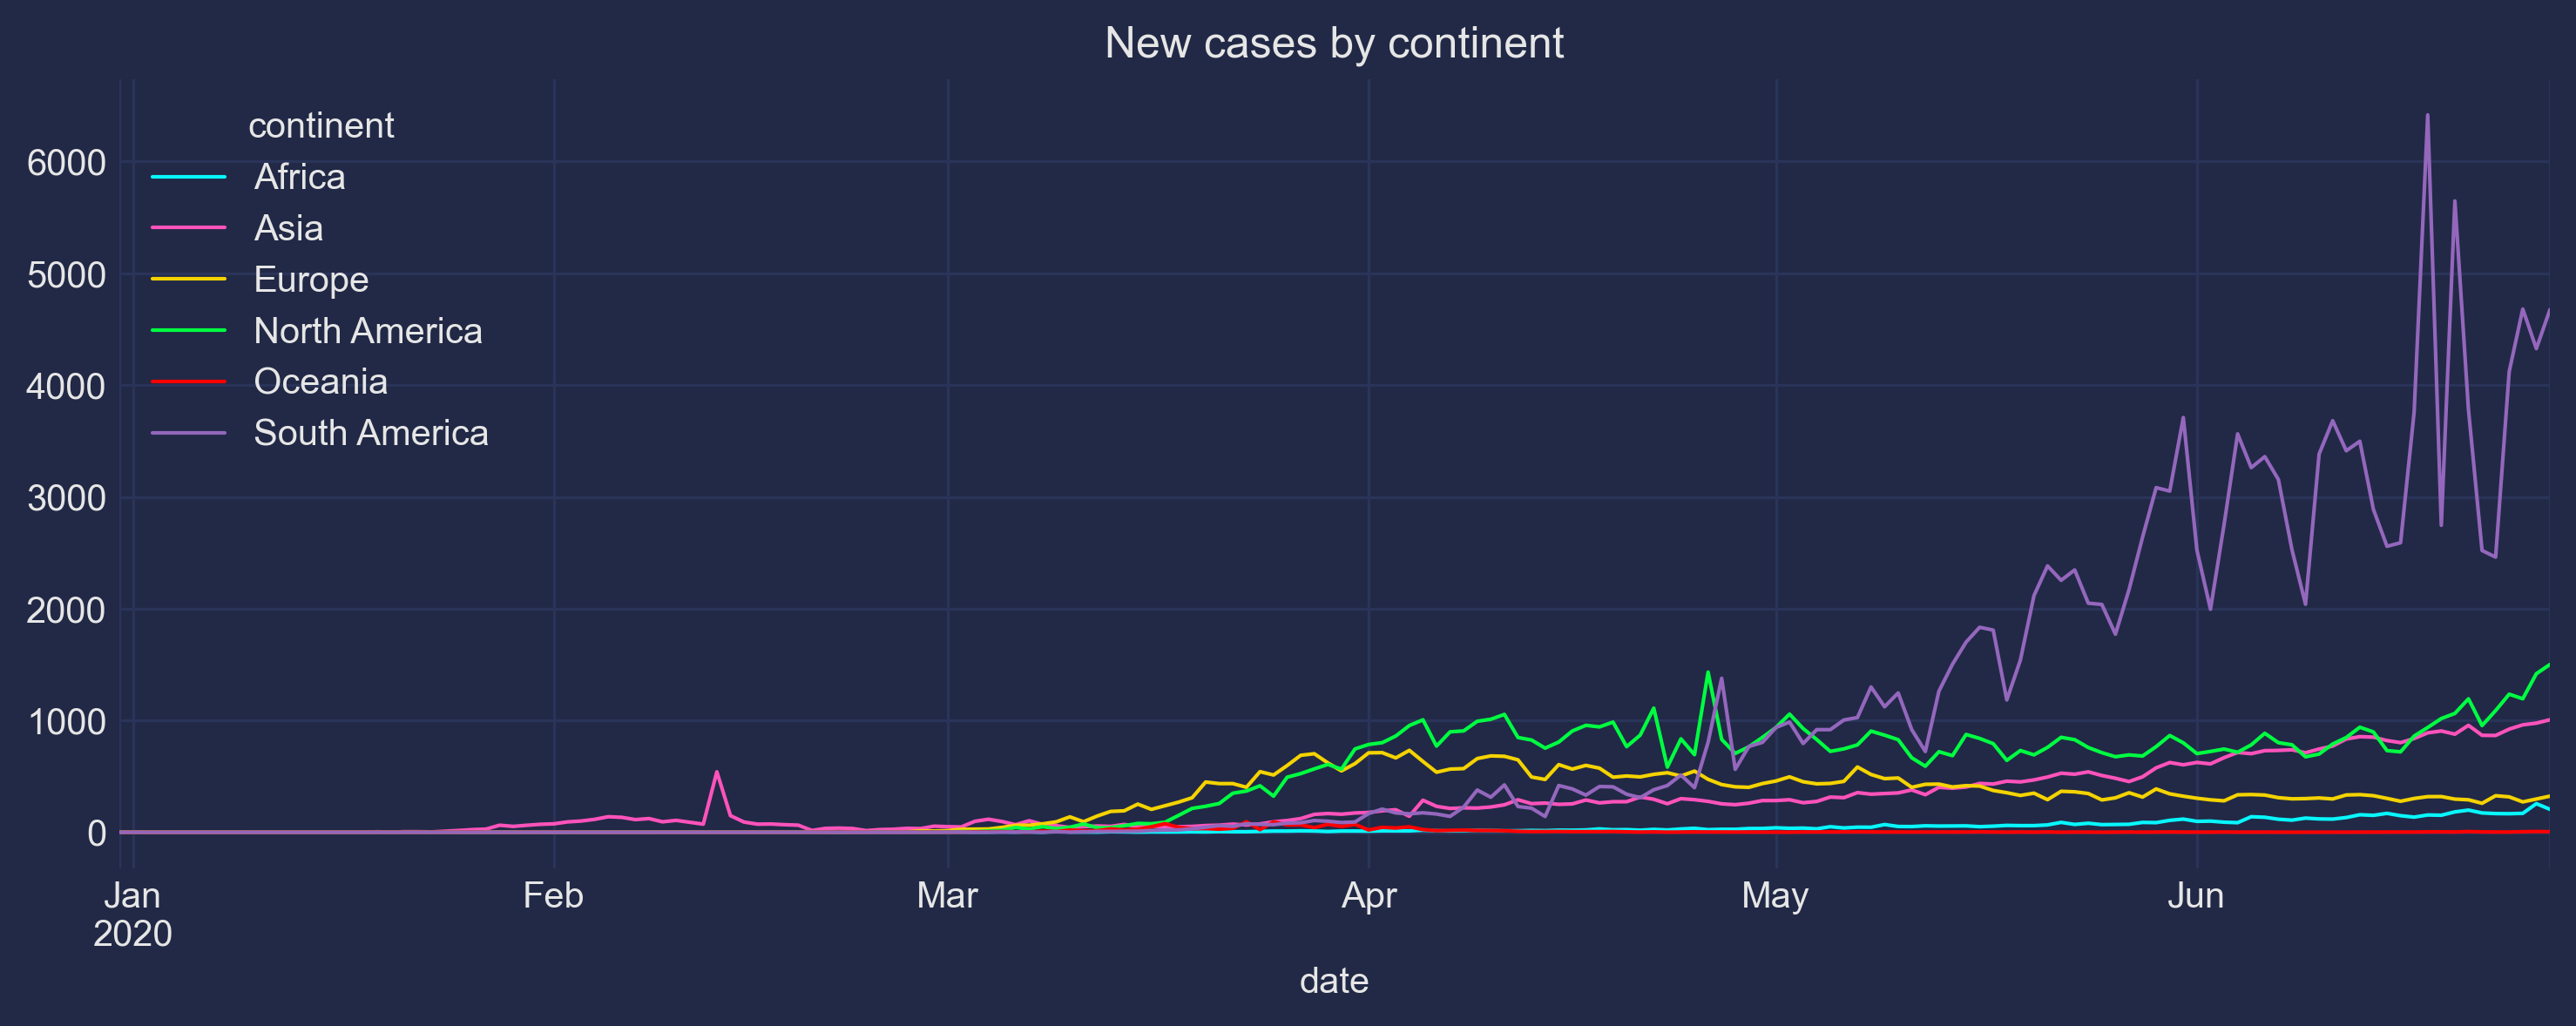

In [261]:
df.pivot_table(values='new_cases', index='date', columns='continent').plot()
plt.title("New cases by continent");

In [295]:
europe = df[df['continent']=='Europe'].pivot_table(values='new_cases', index='date', columns='location')

In [296]:
top = europe.sum().reset_index().sort_values(by=0, ascending=False).iloc[1:6]['location'].to_list()

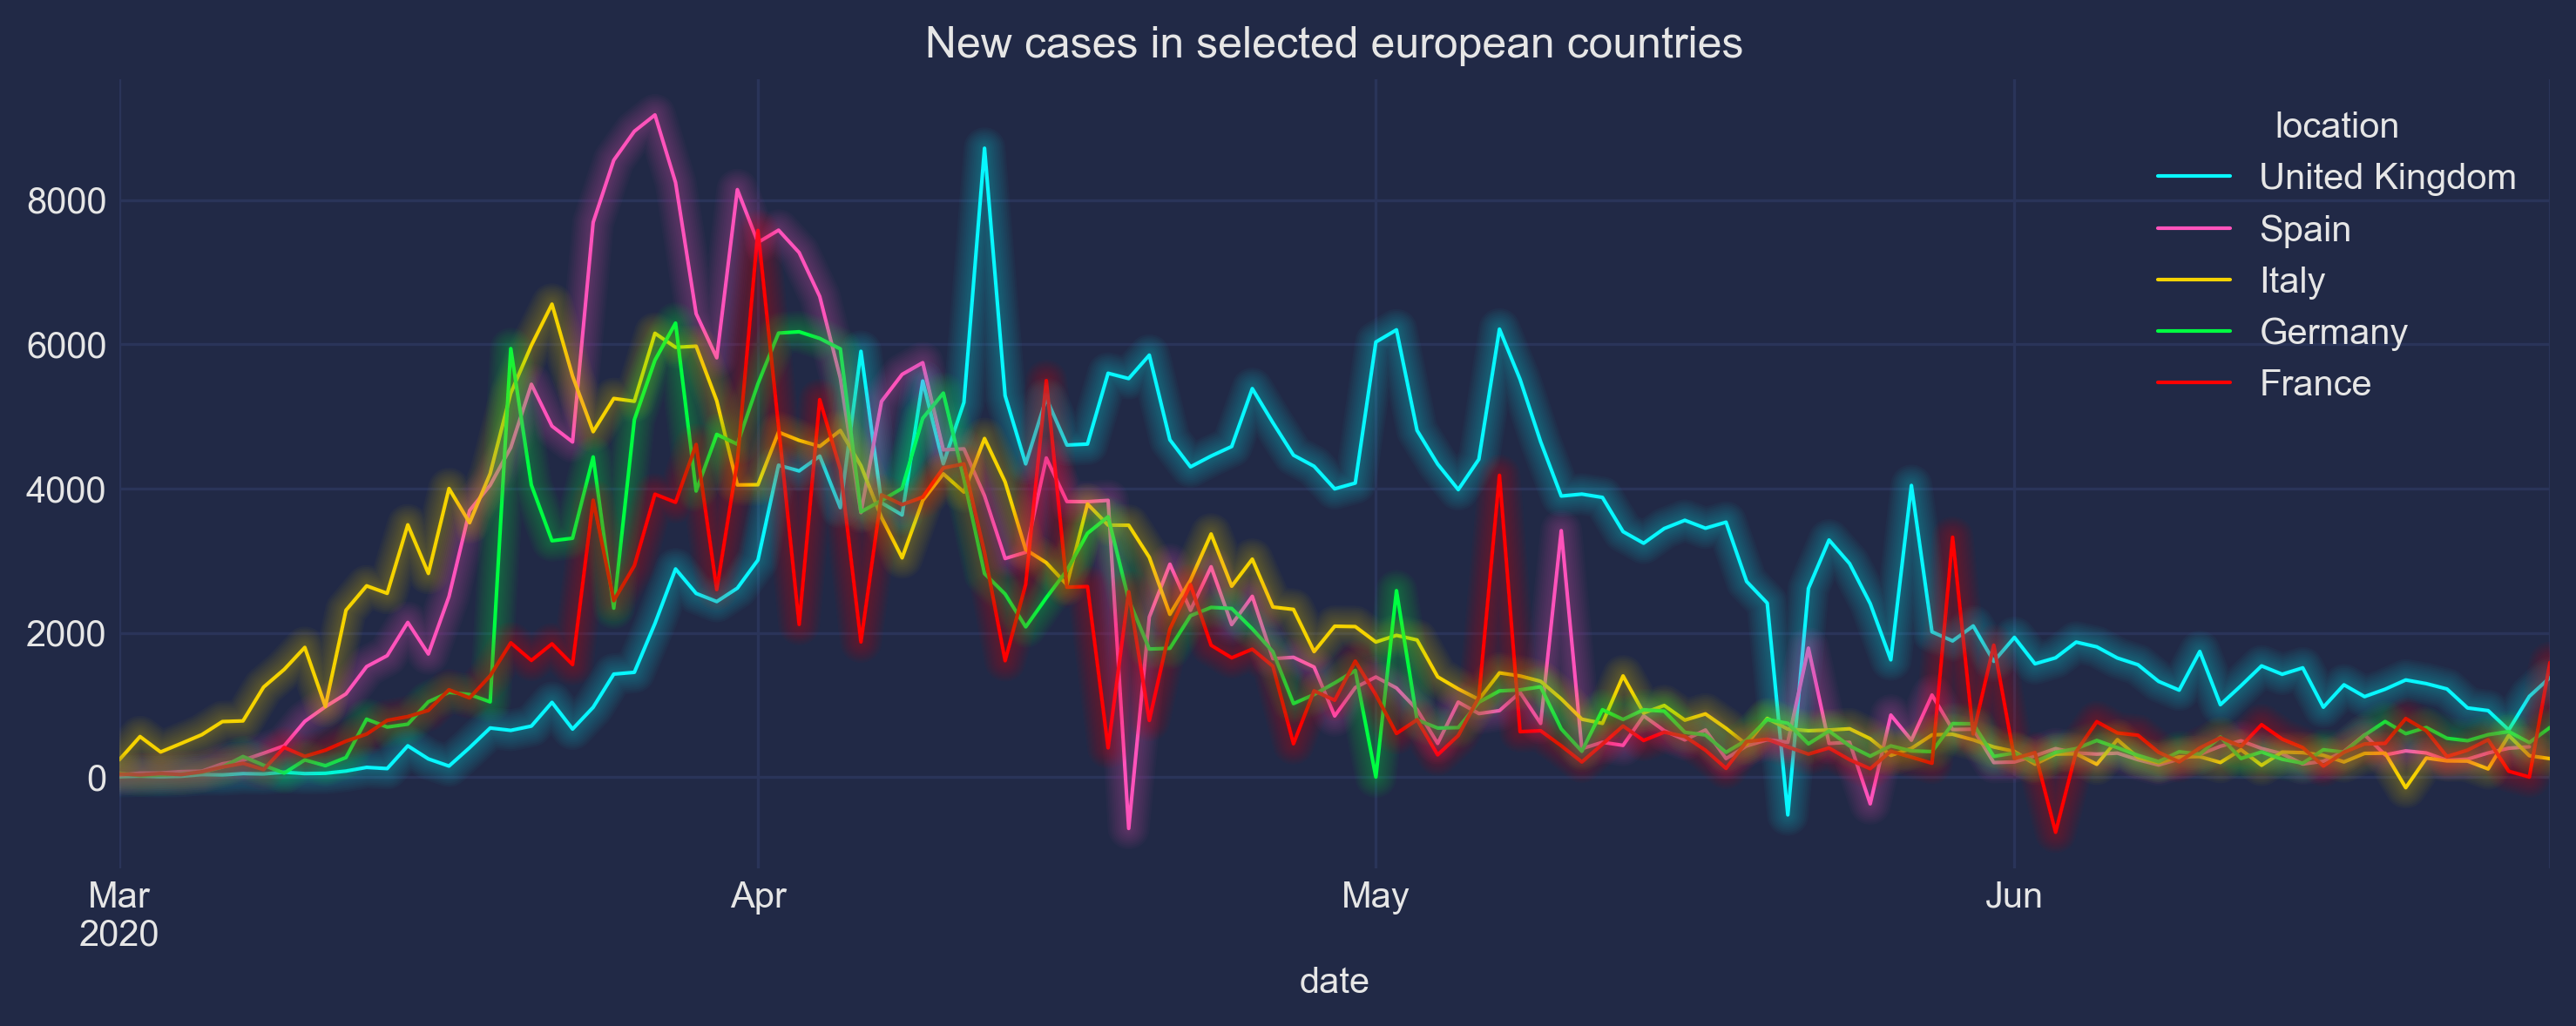

In [297]:
europe[top].loc['2020-03-01':].plot()
plt.title('New cases in selected european countries')
mplcyberpunk.make_lines_glow()

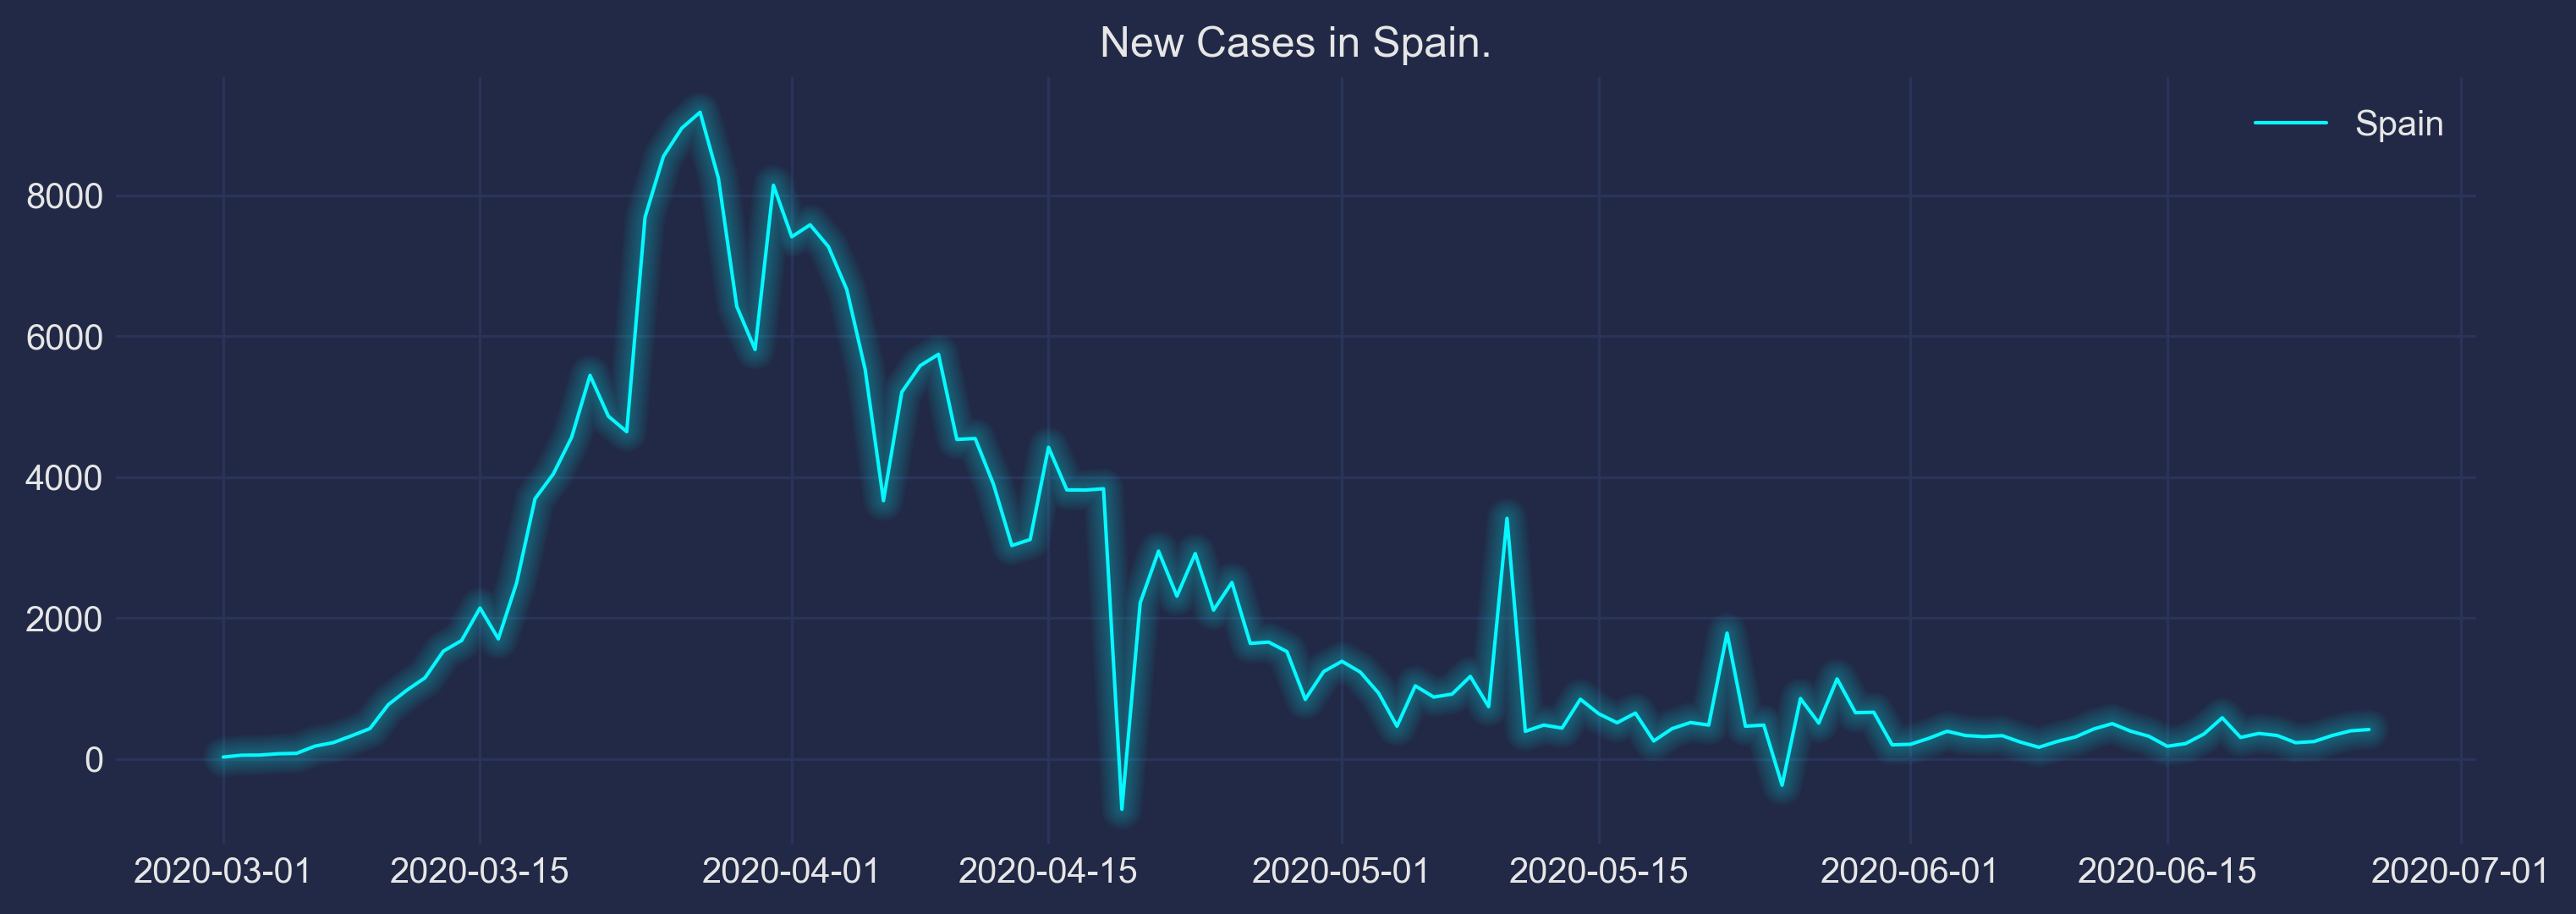

In [288]:
fig, ax = plt.subplots()
ax.plot(df[df['location']==country].loc['2020-03-01':]['new_cases'], label=country)
plt.legend()
plt.title('New Cases in Spain.')
mplcyberpunk.make_lines_glow()

### FBProphet Spain Forecast Model

In [12]:
spain_daily = df[df['location']=='Spain'][['new_cases']].copy()
spain_daily = spain_daily.loc['2020-03-01':]
spain_daily = spain_daily.reset_index()
spain_daily.columns = ['ds', 'y']

train = spain_daily.iloc[:-30]
test = spain_daily.iloc[-30:]

In [230]:
params_grid = {'wfo':[6,8,12,20],
               'dfo':[6,8,12,20],
               'wps':[2,10,15],
               'dps':[2,10,15]}
grid = ParameterGrid(params_grid)

In [231]:
results = []
best_score = 99999
best_forecast = None
best_model = None
for p in tqdm(grid):
    m = Prophet(changepoint_prior_scale = 0.06,
                n_changepoints = 10,
                seasonality_mode = 'multiplicative',
                weekly_seasonality=False,
                daily_seasonality = False,
                yearly_seasonality = True,
                interval_width=0.95)
    m.add_seasonality(name='weekly', period=7, fourier_order=p['wfo'], prior_scale=p['wps'])
    m.add_seasonality(name='daily', period=1, fourier_order=p['dfo'], prior_scale=p['dps'])
    m.fit(train)
    future = m.make_future_dataframe(periods=30)
    forecast = m.predict(future)
    test_eval = test.merge(forecast[['ds', 'yhat']], on='ds', how='left')
    score = np.sqrt(mean_squared_error(test_eval['y'], test_eval['yhat']))
    results.append((p, score))
    if score < best_score:
        best_score = score
        best_forecast = forecast
        best_model = m
        print('Best score found:', score)

Best score found: 426.8987844879362
Best score found: 425.9163769589723
Best score found: 424.69665574915183
Best score found: 185.2701443402451
Best score found: 185.09554404826523
Best score found: 182.34417199018802
Best score found: 161.9788587525876
Best score found: 149.28444312827898
Best score found: 144.03590783954948
Best score found: 138.9840342258985



In [233]:
best_eval = test.merge(best_forecast[['ds', 'yhat']], on='ds', how='left')

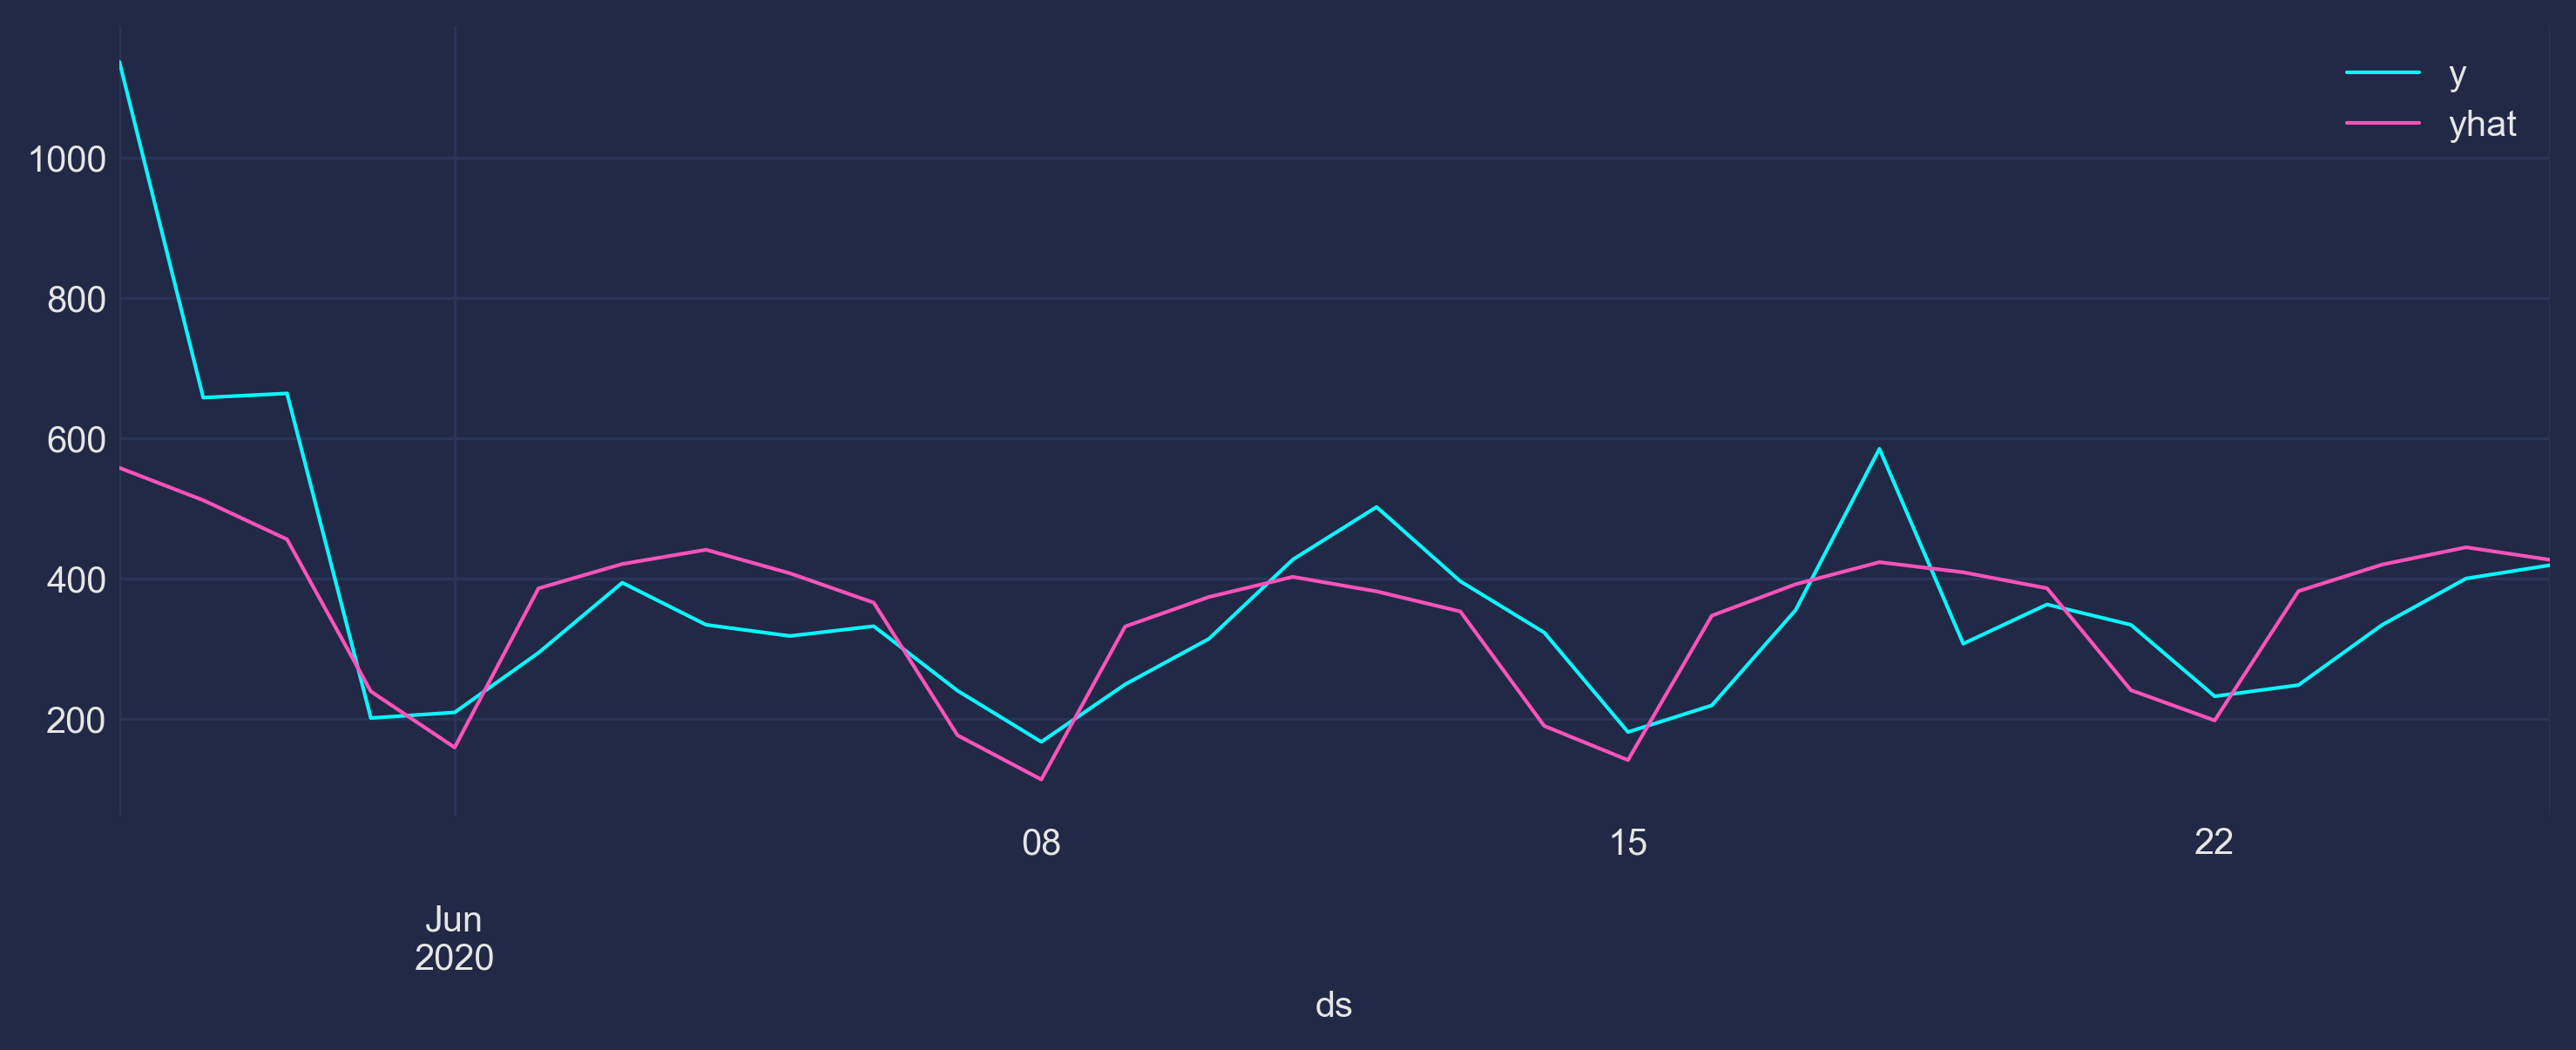

In [234]:
best_eval.set_index('ds').plot();

In [235]:
best_full = spain_daily.merge(best_forecast[['ds', 'yhat']], on='ds', how='left')

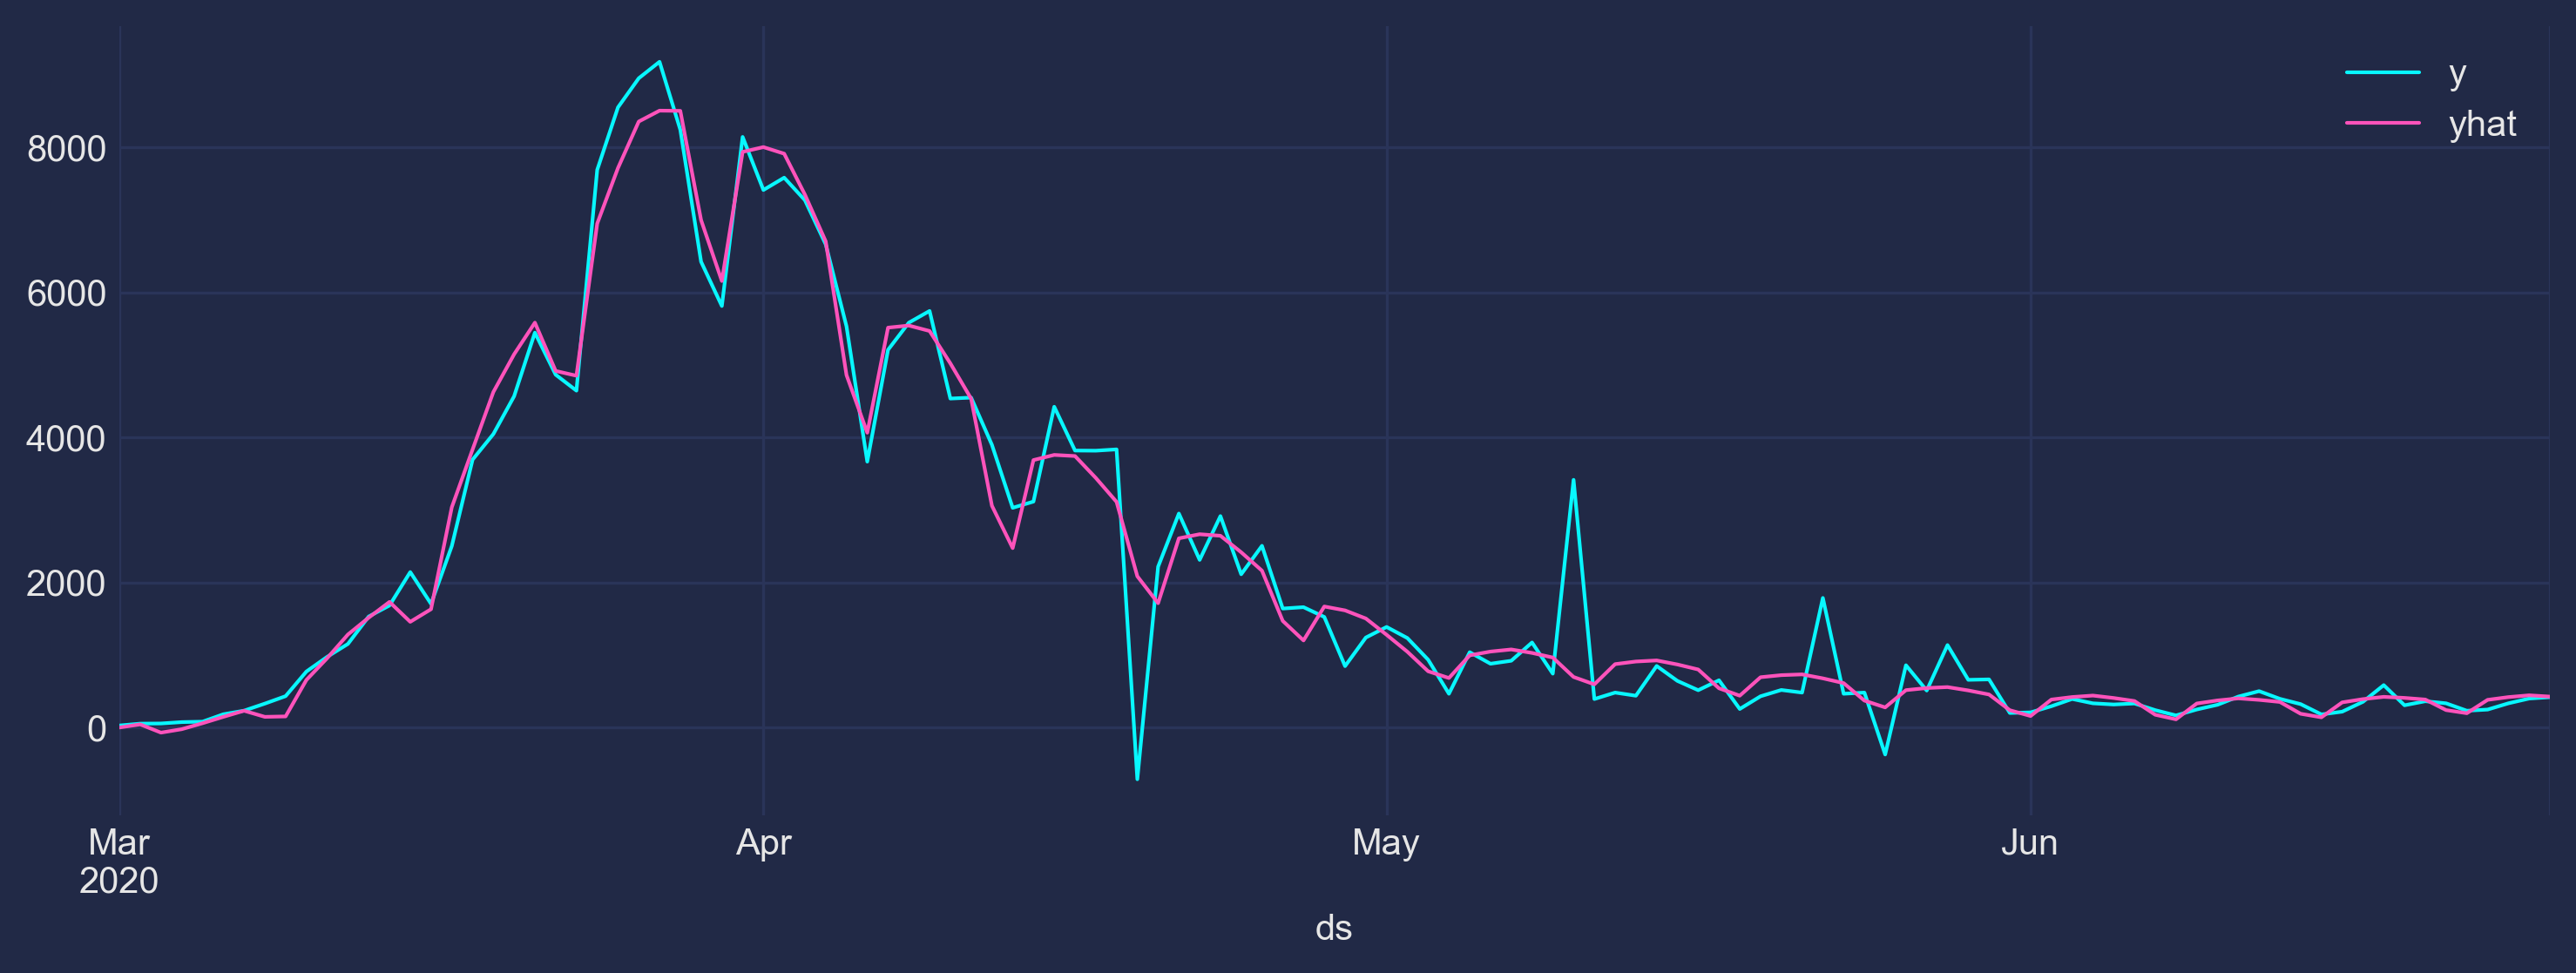

In [236]:
best_full.set_index('ds').plot()

In [237]:
future = best_model.make_future_dataframe(periods=120)
forecast = best_model.predict(future)

In [238]:
full_fc = forecast[['ds', 'yhat']].merge(spain_daily, how='left', on='ds').set_index('ds')

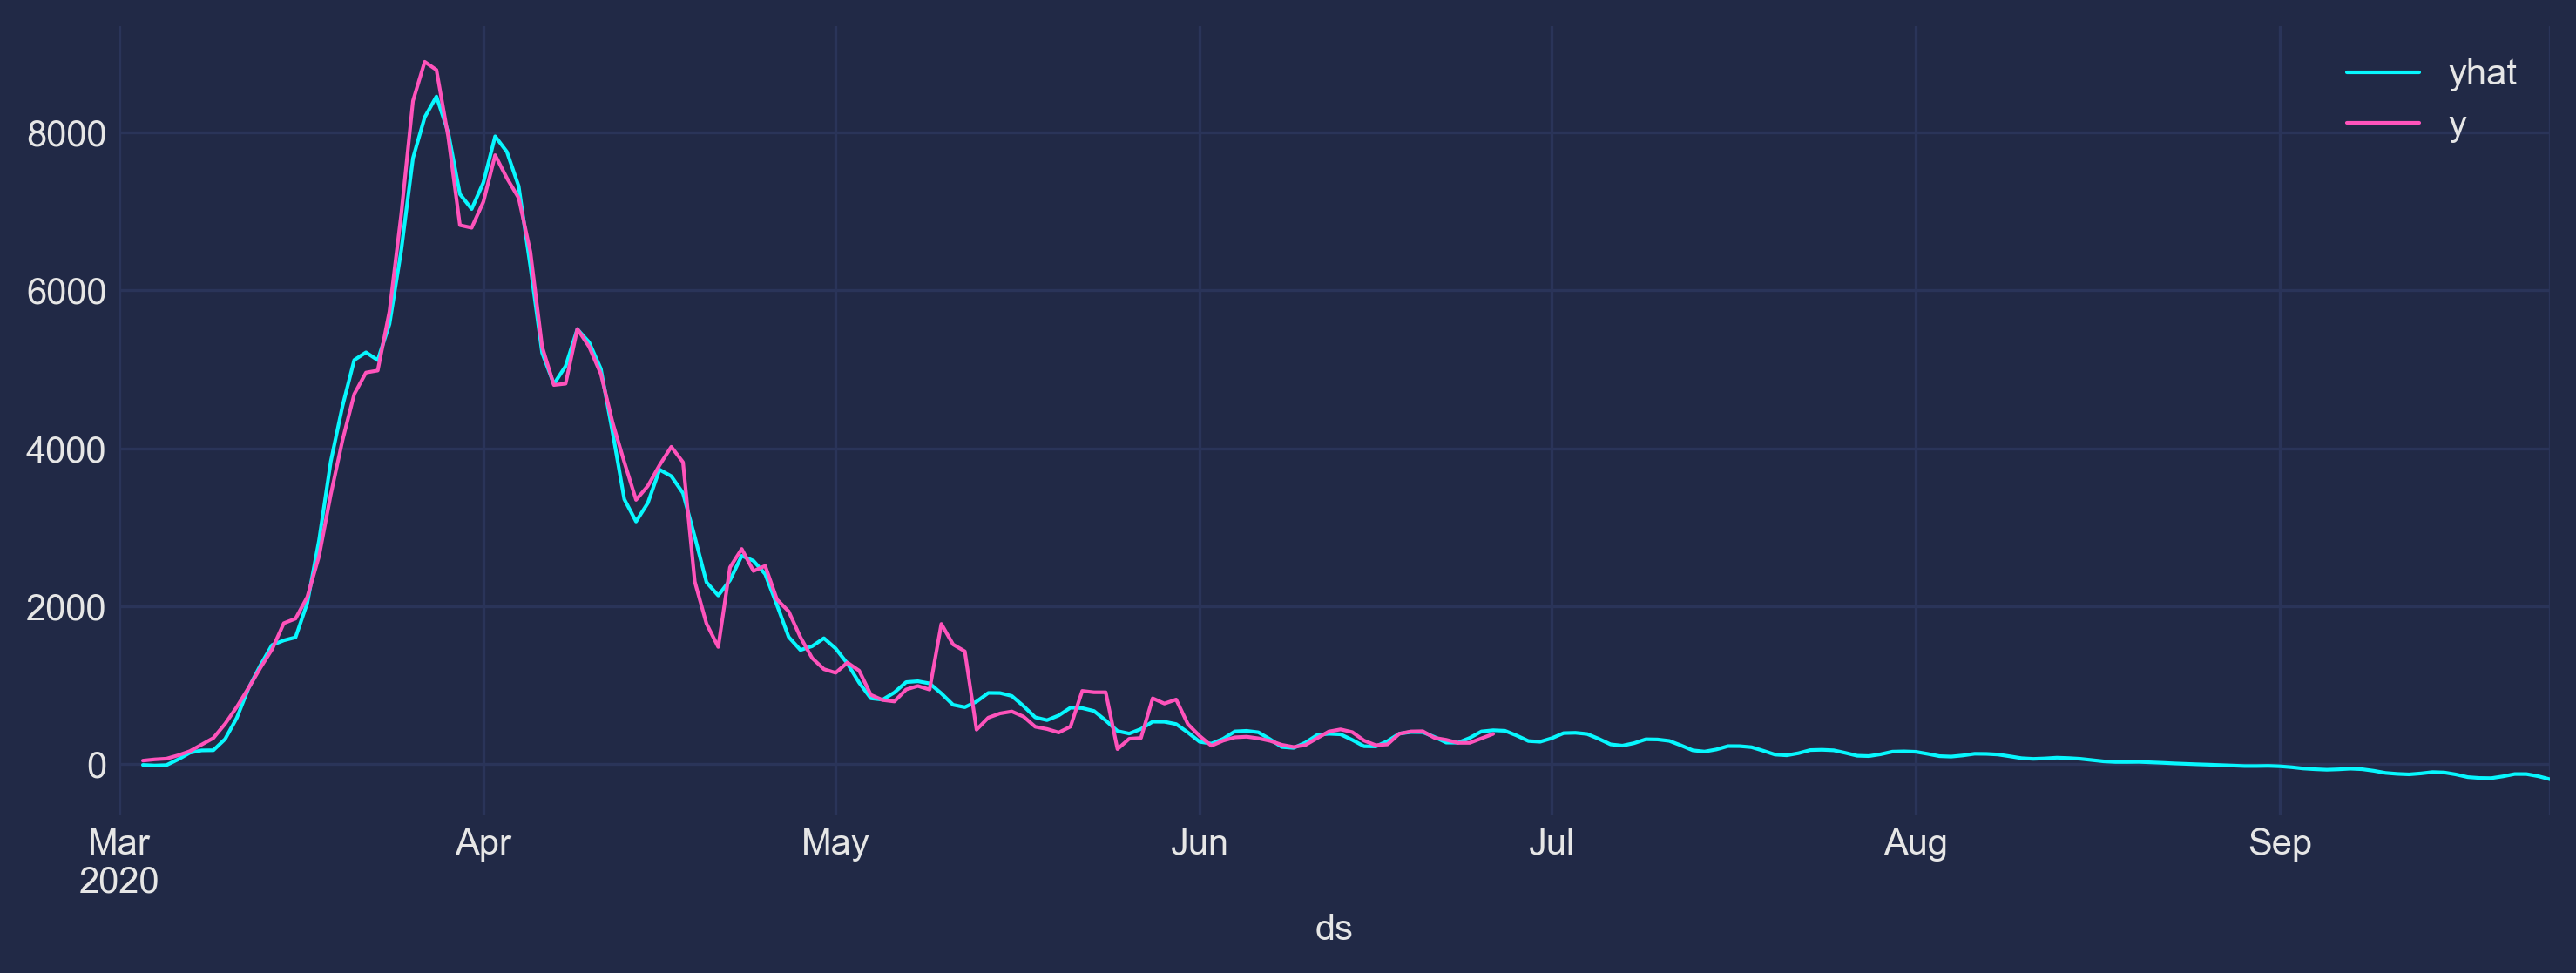

In [239]:
full_fc.rolling(3).mean().plot();

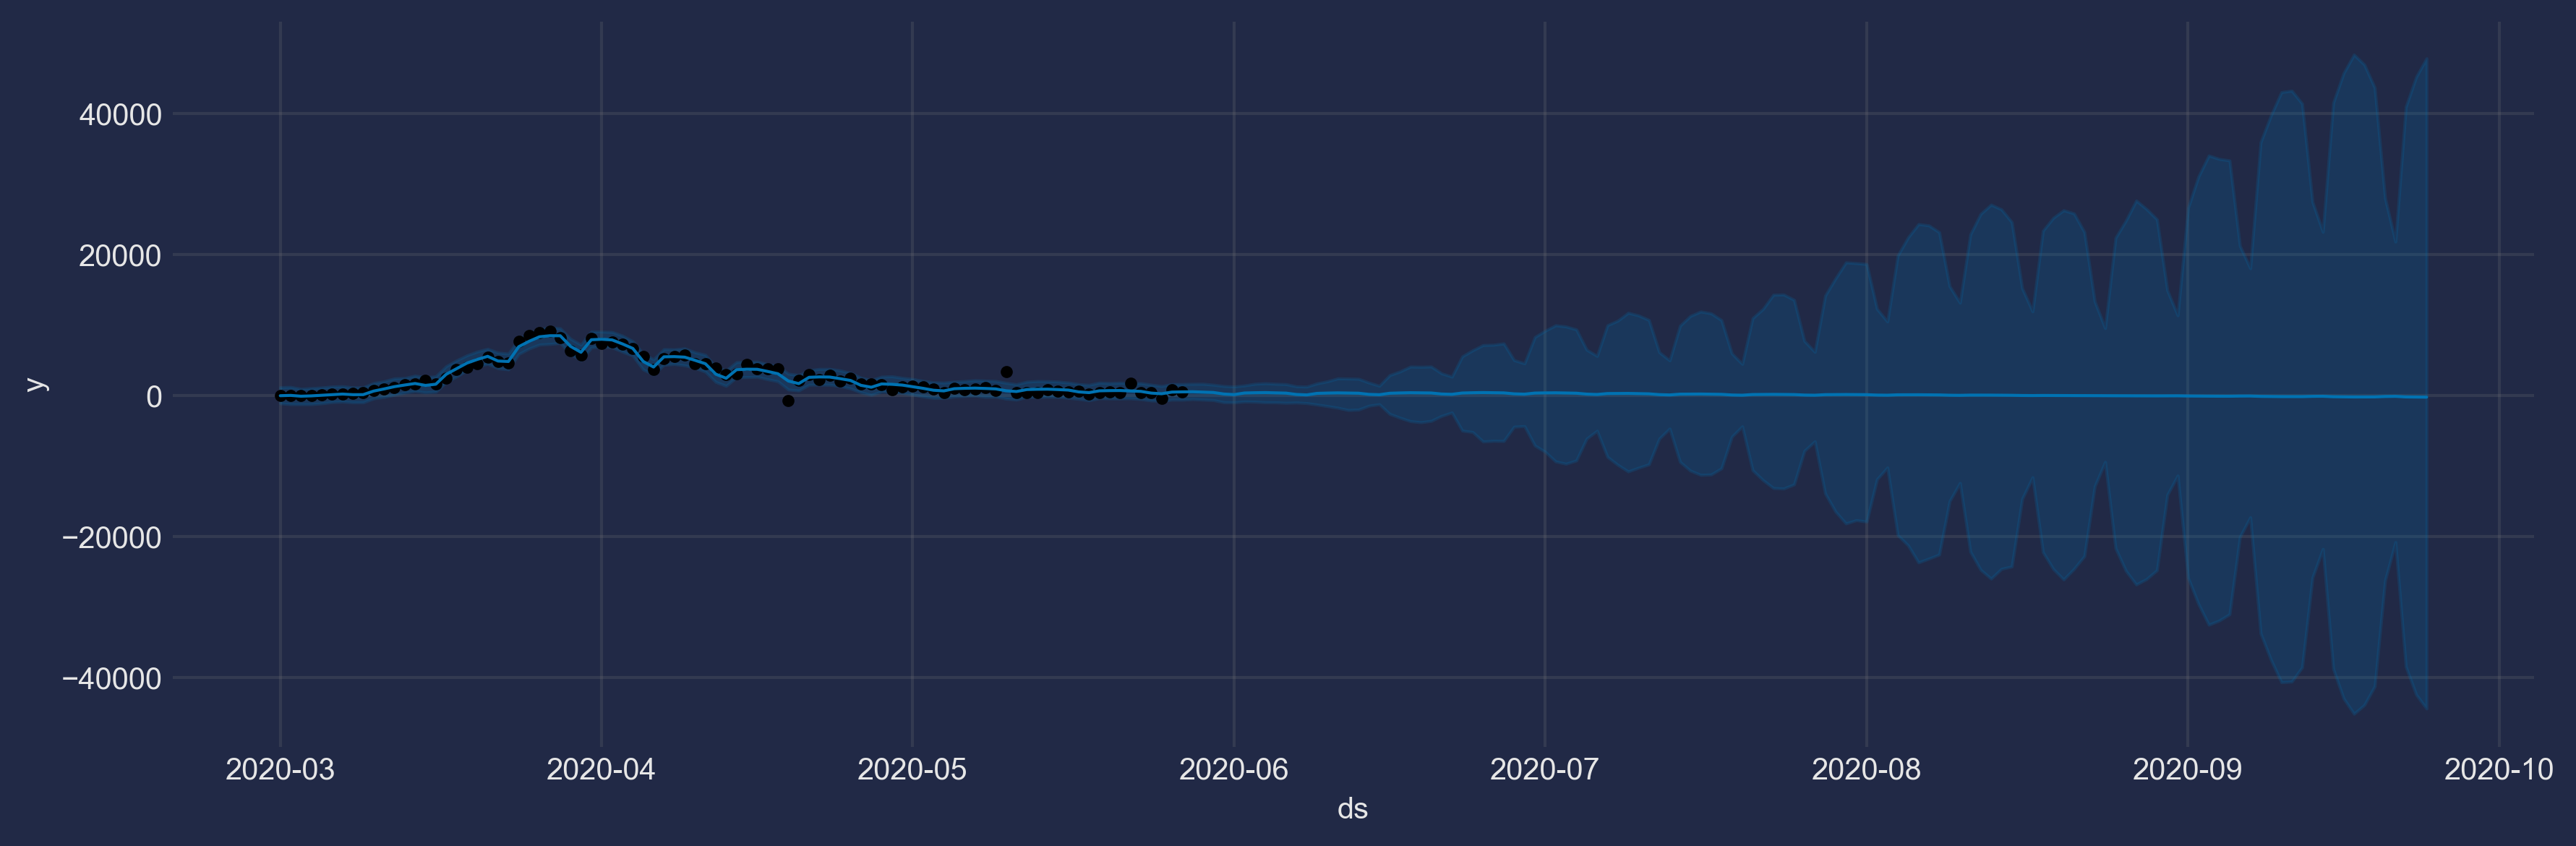

In [240]:
fig, ax = plt.subplots()
best_model.plot(forecast, ax=ax);

In [242]:
stop_date = np.fabs(full_fc['yhat']).reset_index().set_index('ds').loc['2020-06-01':].sort_values(by=['yhat']).iloc[0].name

In [244]:
print('End of Covid19 epidemic in Spain:', stop_date.date())

End of Covid19 epidemic in Spain: 2020-08-24
